In [6]:
import os
import src.finance_model as fm
import src.finance_data_api as fd
import src.market as mkt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

from matplotlib.pylab import rcParams

In [9]:
% matplotlib inline
warnings.simplefilter('ignore')

def get_pred_on_valid_data(ticker, identifier, stock):
    # Load the stock and the models
    data = stock.data()

    cutoff = int(-0.1*len(data))

    # Prepare inputs and perform predictions for outputs
    inputs = data[identifier][cutoff:].values
    inputs = inputs.reshape(-1,1)
    inputs  = stock._scalers[identifier].transform(inputs)

    X_test = []
    for i in range(60, inputs.shape[0]):
        X_test.append(inputs[i-60:i, 0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
    outputs = stock.get_model(identifier).predict(X_test)
    outputs = stock._scalers[identifier].inverse_transform(outputs)
    
    return outputs
    

def make_plots_model_1_all_data(company, ticker, stock):
    
    # Load the stock and the models
    
    data = stock.data()

    cutoff = int(-0.1*len(data))

    # Make predictions on validation data
    opening_price = get_pred_on_valid_data(ticker, 'Open', stock)
    closing_price = get_pred_on_valid_data(ticker, 'Close', stock)
    model_gaps = get_pred_on_valid_data(ticker, 'Gap', stock)    

    # Make plots for the stock
    rcParams['figure.figsize'] = 20, 10
    plot_data = data[cutoff + 60:]
    plot_data['Open Predictions'] = opening_price
    plot_data['Close Predictions'] = closing_price
    plot_data['Gap Predictions'] = model_gaps

    f, axarr = plt.subplots(2, 2, sharey=True)
    f.suptitle(f'{company} Stock Model 1', fontsize=16, fontweight='bold')

    # Plot opening prices
    axarr[0][0].plot(data['Open'])
    axarr[0][0].set_title('Opening Prices', fontweight='bold')
    axarr[0][0].set_ylabel('Stock Value (USD)')
    axarr[0][0].legend(loc='upper left', prop={'size': 12})

    # Plot opening prices alongside the predicted opening prices
    axarr[0][1].plot(plot_data['Open'])
    axarr[0][1].plot(plot_data['Open Predictions'])
    axarr[0][1].set_title('Opening Prices Predictions', fontweight='bold')
    axarr[0][1].legend(loc='upper left', prop={'size': 12})

    # Plot closing prices
    axarr[1][0].plot(data['Close'])
    axarr[1][0].set_title('Closing Prices', fontweight='bold')
    axarr[1][0].set_xlabel('Date')
    axarr[1][0].set_ylabel('Stock Value (USD)')
    axarr[1][0].legend(loc='upper left', prop={'size': 12})

    # Plot closing prices alongside the predicted closing prices
    axarr[1][1].plot(plot_data['Close'])
    axarr[1][1].plot(plot_data['Close Predictions'])
    axarr[1][1].set_title('Closing Prices Predictions', fontweight='bold')
    axarr[1][1].set_xlabel('Date')
    axarr[1][1].legend(loc='upper left', prop={'size': 12})
    
    path = f'../plots/{ticker.lower()}/'
    try:
        os.mkdir(path)
    except FileExistsError:
        pass
    
    plt.savefig(path + 'model_1_results')
    
    
def make_plots_model_2_all_data(company, ticker, stock):
    
    # Load the stock and the models
    stock = mkt.Stock(ticker, model_path='../models/' + ticker.lower() + '/all_data/')
    data = stock.data()

    cutoff = int(-0.1*len(data))

    # Make predictions on validation data
    opening_price = get_pred_on_valid_data(ticker, 'Open', stock)
    closing_price = get_pred_on_valid_data(ticker, 'Close', stock)
    model_gaps = get_pred_on_valid_data(ticker, 'Gap', stock)    

    # Make plots for the stock
    rcParams['figure.figsize'] = 20, 10
    plot_data = data[cutoff + 60:]
    plot_data['Open Predictions'] = opening_price
    plot_data['Close Predictions'] = closing_price
    plot_data['Gap Predictions'] = model_gaps

    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    f.suptitle(f'{company} Stock', fontsize=16, fontweight='bold')
    
    # Plot closing prices
    ax1.plot(data['Gap'])
    ax1.set_title('Gap', fontweight='bold')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Gap in Close and Open Prices')
    ax1.legend(loc='upper left', prop={'size': 12})

    # Plot closing prices alongside the predicted closing prices
    ax2.plot(plot_data['Gap'])
    ax2.plot(plot_data['Gap Predictions'])
    ax2.set_title('Gap in Close and Open Prices', fontweight='bold')
    ax2.set_xlabel('Date')
    ax2.legend(loc='upper left', prop={'size': 12})
    
    path = f'../plots/{ticker.lower()}/'
    try:
        os.mkdir(path)
    except FileExistsError:
        pass
    
    plt.savefig(path + 'model_2_results')
    
    
    
def compute_results(ticker, stock):
    results = {}
    
    # Load the stock and the models
    data = stock.data()
    
    cutoff = int(-0.1*len(data))

    opening_price = get_pred_on_valid_data(ticker, 'Open', stock)
    closing_price = get_pred_on_valid_data(ticker, 'Close', stock)
    model_gaps = get_pred_on_valid_data(ticker, 'Gap', stock)

    # Perform analysis
    valid_data = data[cutoff + 60:]
    count1 = count2 = 0
    n = len(valid_data)
    gaps = valid_data['Gap'].values
    pred_gaps = closing_price - opening_price

    for i in range(n-1):
        if gaps[i] >= 0 and pred_gaps[i] >= 0:
            count1 += 1
        elif gaps[i] < 0 and pred_gaps[i] < 0:
            count1 += 1
        elif gaps[i] >= 0 and model_gaps[i] >= 0:
            count2 += 1
        elif gaps[i] < 0 and model_gaps[i] < 0:
            count2 += 1
        
    p1 = count1 / n
    p2 = count2 / n
    
    results['Probability'] = [p1, p2]
    
    df = pd.DataFrame.from_dict(results)
    df.index = ['Model 1', 'Model 2']
    print(df)
    
def perform_analysis(company, ticker):
    stock = mkt.Stock(ticker, model_path='../models/' + ticker.lower() + '/all_data/')
    make_plots_model_1_all_data(company, ticker, stock)
    make_plots_model_2_all_data(company, ticker, stock)
    compute_results(ticker, stock)
    

         Probability
Model 1     0.536151
Model 2     0.000000


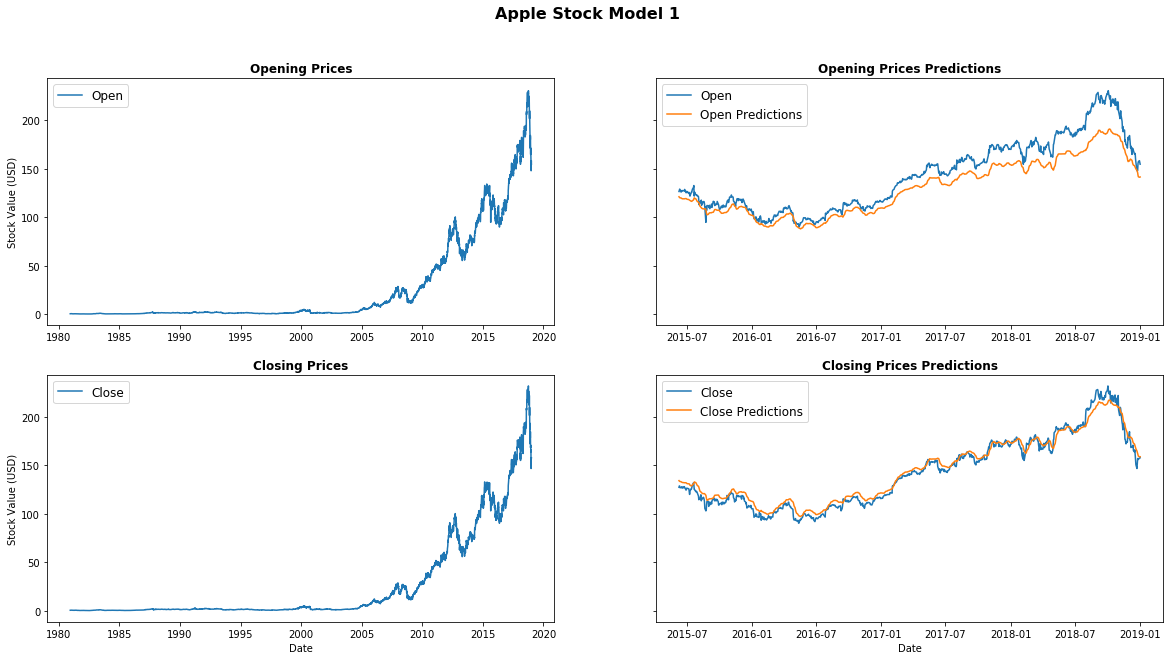

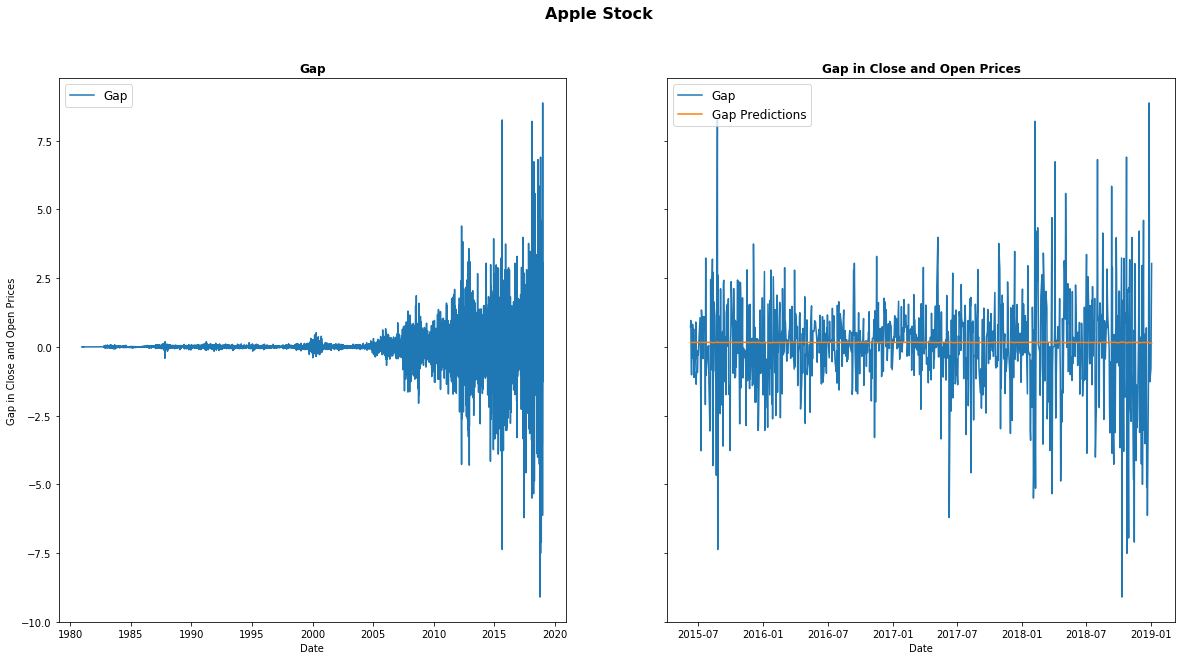

In [10]:
perform_analysis('Apple', 'AAPL')

### Opening Prices
From the upper right hand plot, we can tell that the model does a relatively good job at predicting, however, it seems that it consistently underestimates the opening price. One reason why this might be happening is due to the fact that the model network was trained on data from 1981 up until about 2015. If you look at the opening prices from 1981 to 2000 their is not much movement occuring, and therefore not much information being gained. Therefore, it might be better to train on data starting with the year 2000.

### Closing Prices
As we then switch to observing the model for closing prices, we see a similar pattern occuring. In this situation, however, it seems that the model is overestimating the closing prices. These problems might be arising from a similar issue. If we look at the closing prices from 1981 to 2000, there is low movement.

### Issues
These observations force the need for retraining, because if we were to use these to predict whether or not the stock would go up or down, it would consistently tell us that it would go up. This is due to the fact of the opening price model underestimating and the closing price model overestimating. Therefore, we will train the model on data from 2000 and look at these charts again.

         Probability
Model 1     0.497934
Model 2     0.035124


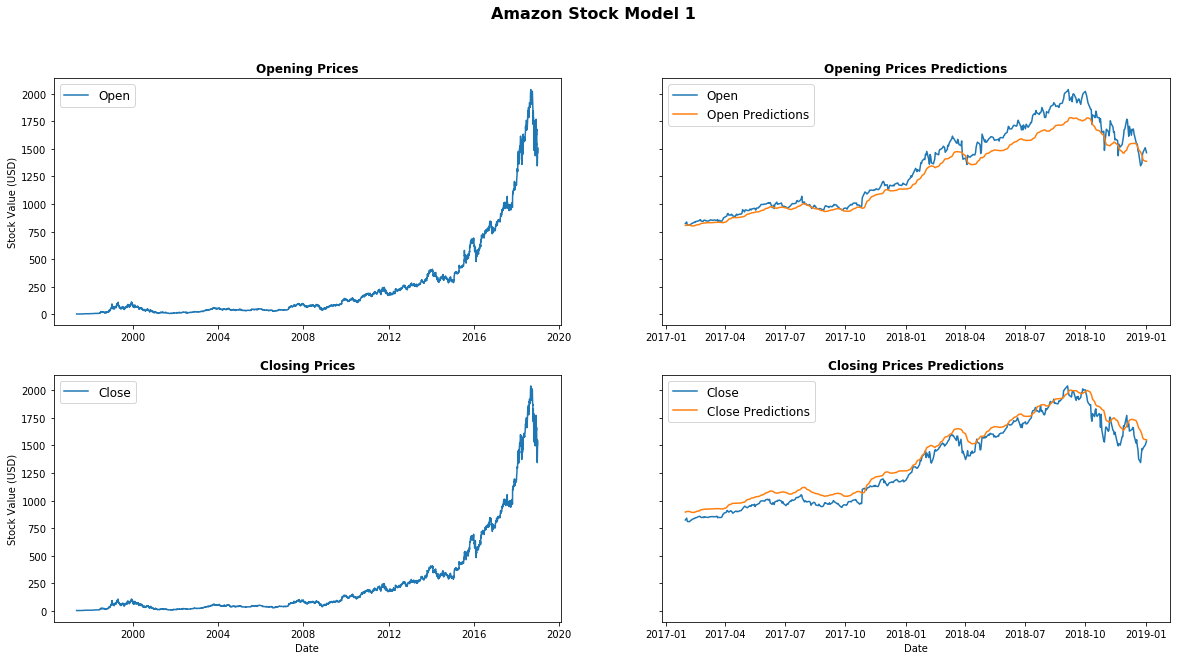

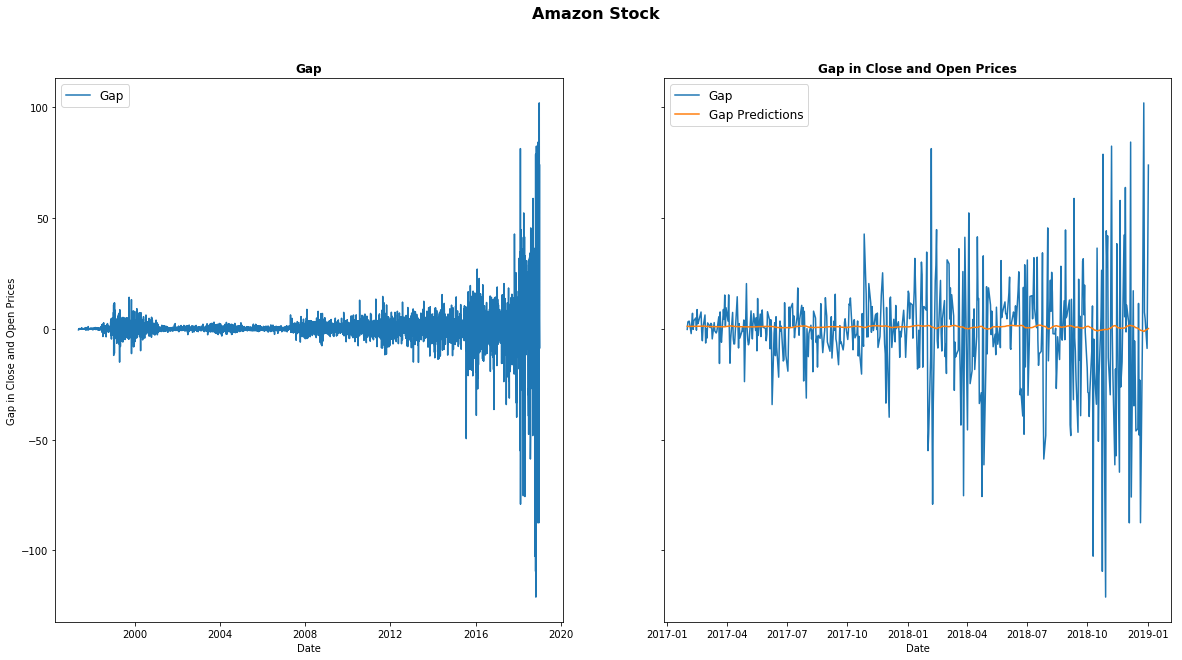

In [11]:
perform_analysis('Amazon', 'AMZN')

         Probability
Model 1     0.509434
Model 2     0.075472


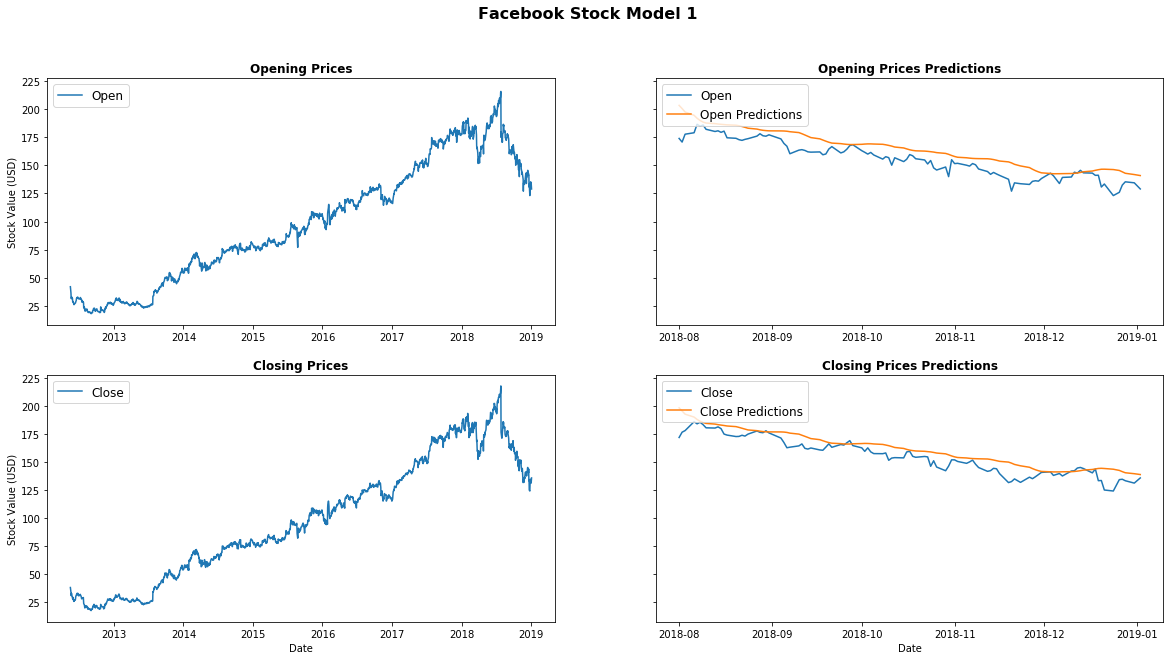

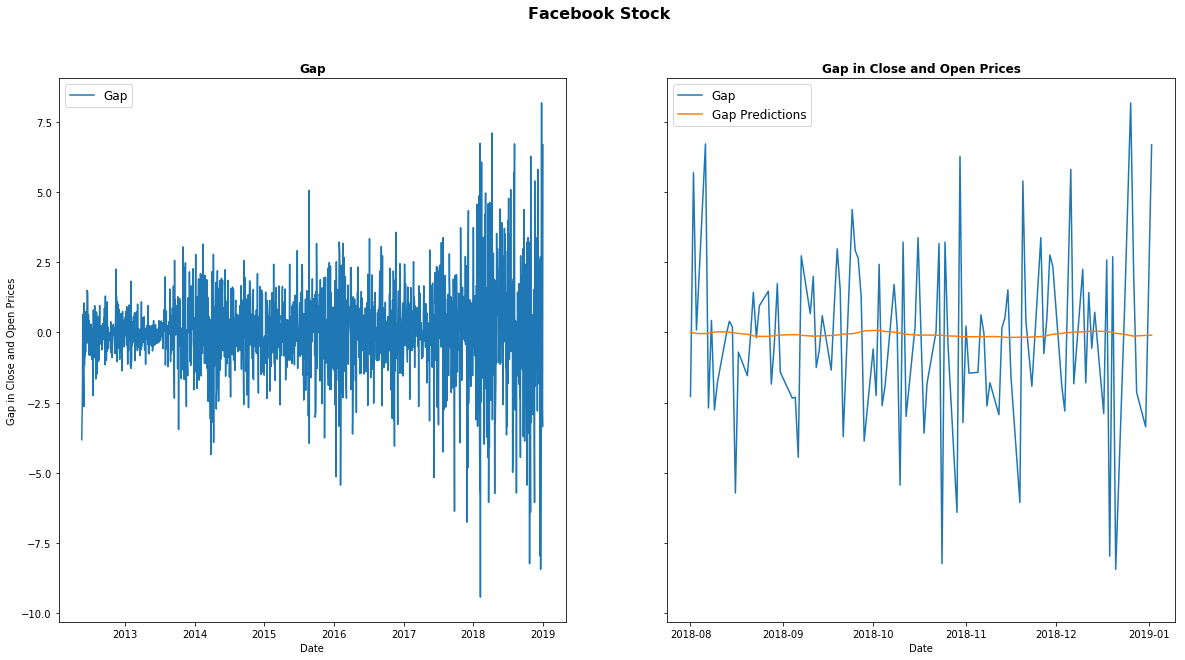

In [12]:
perform_analysis('Facebook', 'FB')

         Probability
Model 1     0.508306
Model 2     0.000000


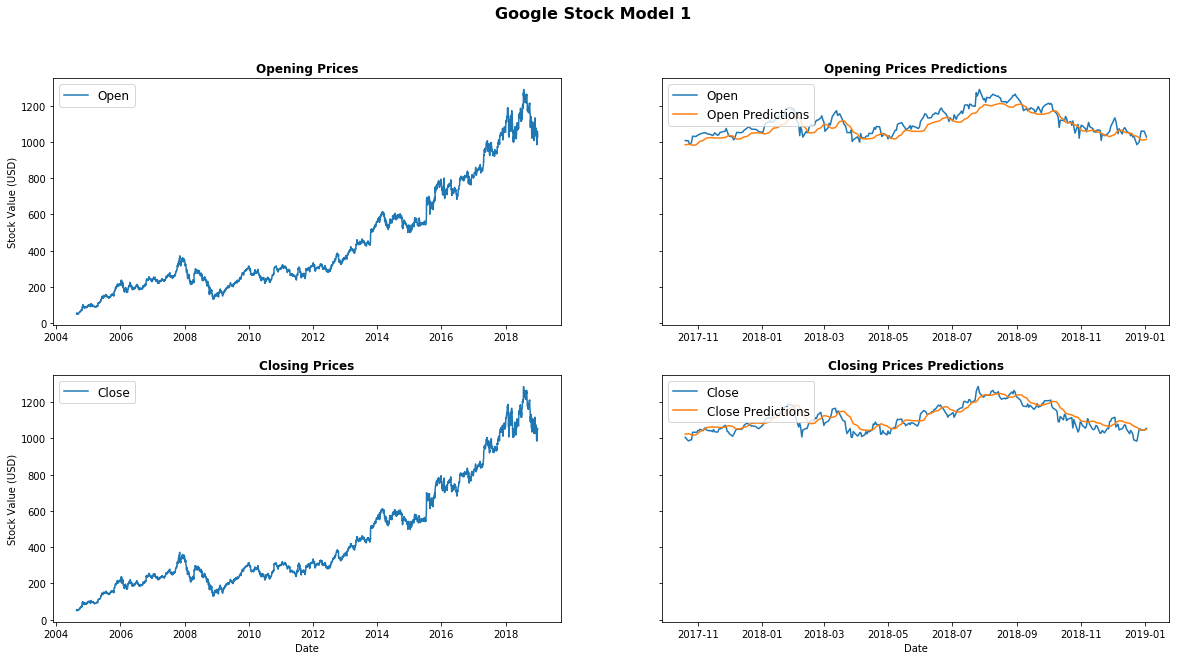

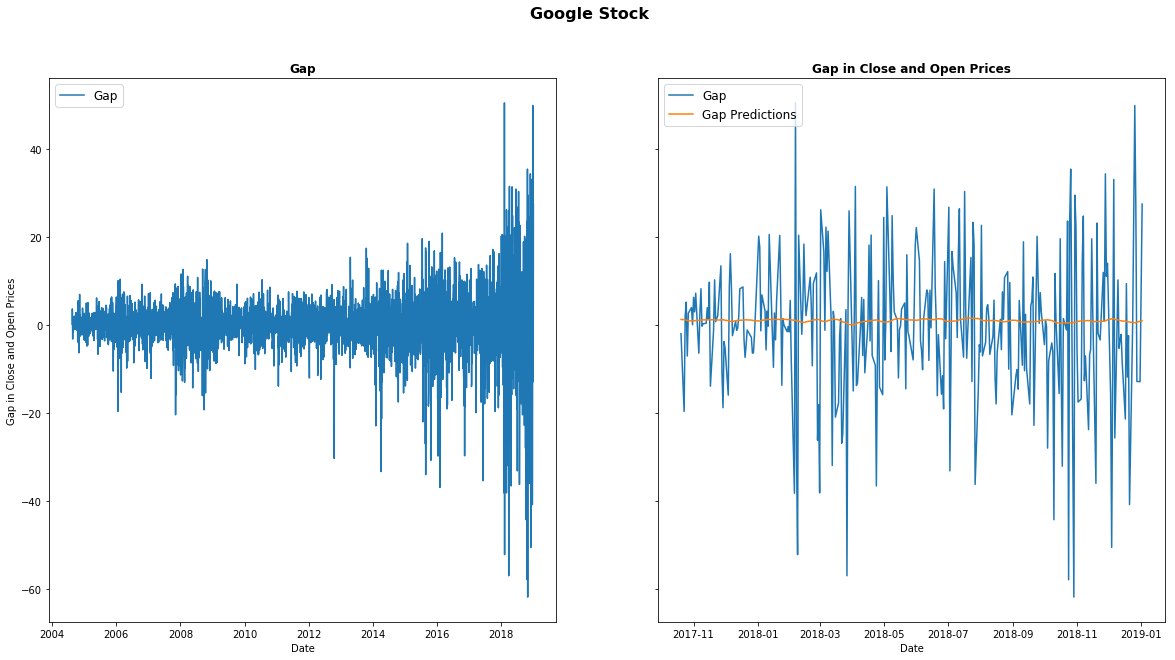

In [13]:
perform_analysis('Google', 'GOOGL')

         Probability
Model 1     0.505822
Model 2     0.483261


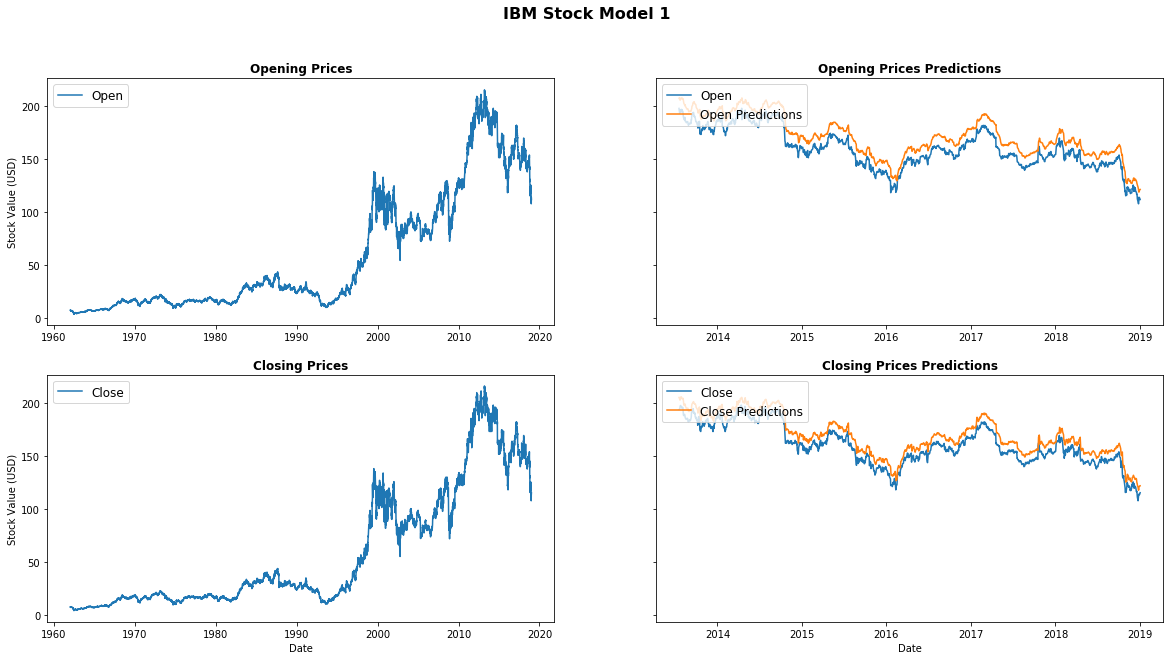

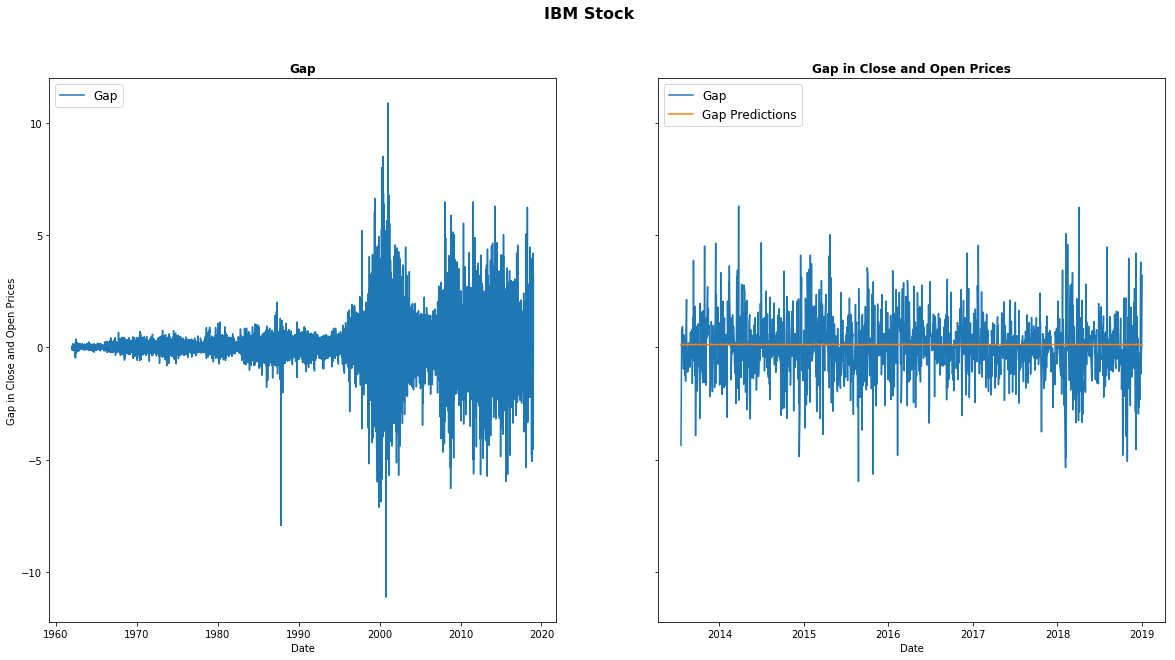

In [14]:
perform_analysis('IBM', 'IBM')

         Probability
Model 1     0.526728
Model 2     0.015645


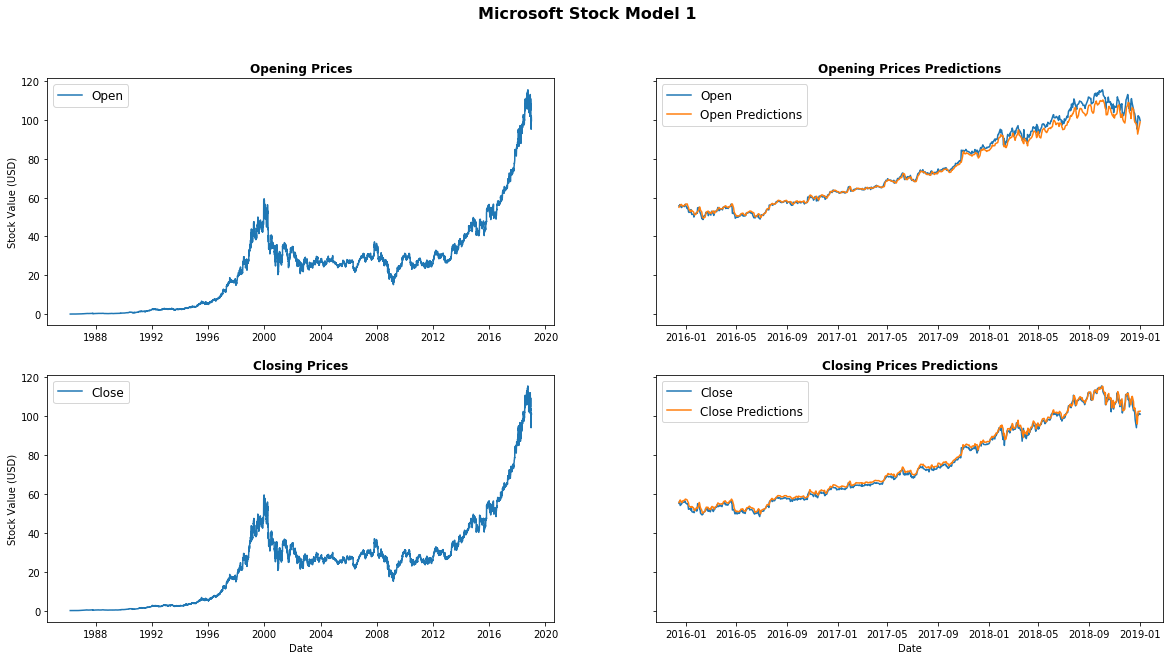

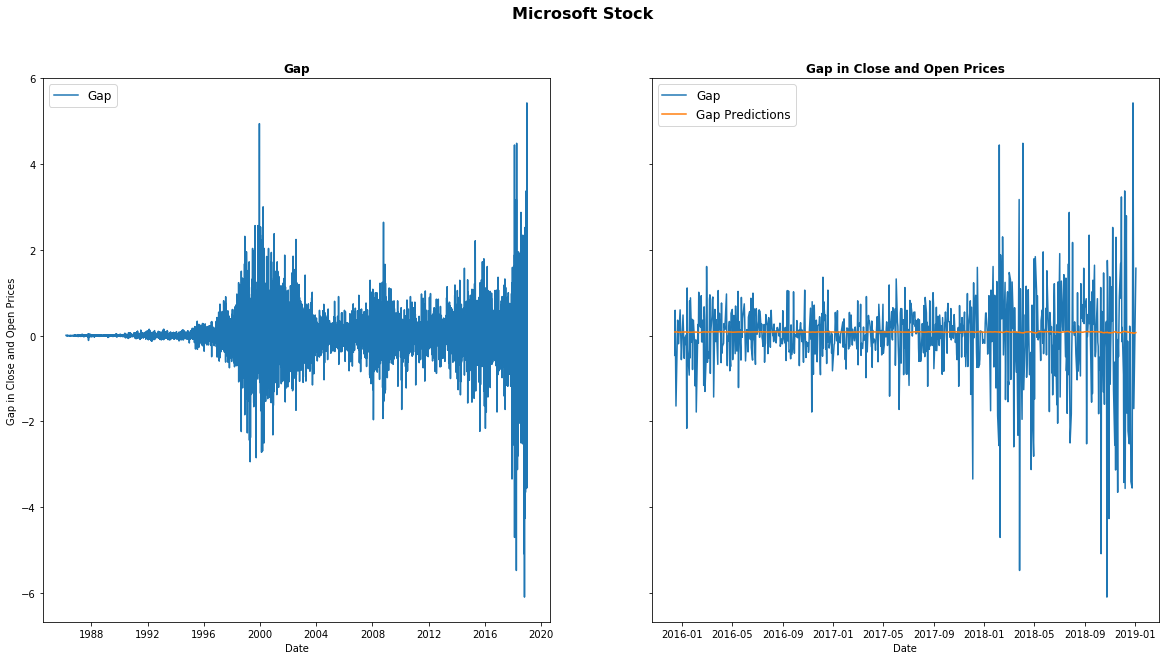

In [15]:
perform_analysis('Microsoft', 'MSFT')